# Is the Hype Real?

The objective of the following web scrapping project is to analyze and visualize the relationship between a game Youtube release trailer and its review score. We want to explore the possibility that either the number of views of the game's release trailer or the ratio of likes/dislikes has some predictive power over the final score the game will receive from the specialized media.

Is the Hype Real seeks to explore the effects of Hype, simply defined as high expectations of a product. In this case, the product will be a game. The proxy for hype will be number of youtube views of the game release trailer, as well as like/dislike ratio of the video. We will assume that the Gamespot and Metacritic review scores are good proxies for fundamental quality of these games.

We start by importing all the libraries and extensions we are going to need in one cell

In [1]:
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import urllib.request
import urllib.parse
import re

### Part 1 - Getting Youtube and GameSpot Data

This part is divided in 5 key functions that can be rearranged in a class in the future. 

**1.** The first function takes as an input a game name in string format and through urllib it requests the first result showed on a Youtube search. The output is a string with the link to the video.

*We add 'launch trailer' to every game inputed in order for the first result on youtube search to be more accurate.

In [2]:
def get_youtube_link(x):     #reference the code here
    query_string = urllib.parse.urlencode({"search_query" : x + 'Launch Trailer'})
    html_content = urllib.request.urlopen("http://www.youtube.com/results?" + query_string)
    search_results = re.findall(r'href=\"\/watch\?v=(.{11})', html_content.read().decode())
    youtube_page = "http://www.youtube.com/watch?v=" + search_results[1]
    return youtube_page

**2.** The second function has the same input as the first one, but outputs the gamespot page for the game. TRABALHAR AQUI

In [3]:
def gamespot_search_name(game_name):
    return "https://www.gamespot.com/" + game_name.replace(" ", "-").replace(":", "").replace("'","").casefold()

**3.** This function is the first one to actually perform web scrapping. It has as its input the youtube url provided by the first function, and outputs the name of the video, views, date it was published on Youtube as well as the number of likes and dislikes.

In [4]:
def get_video_info(url):
    # download HTML code
    content = requests.get(url)
    # create beautiful soup object to parse HTML
    soup = BeautifulSoup(content.content, "html.parser")
    # initialize the result
    result = {}
    result['video_title'] = soup.find("span", attrs={"class": "watch-title"}).text.strip()
    result['views'] = int(soup.find("div", attrs={"class": "watch-view-count"}).text[:-6].replace(",", ""))
    result['date_published_yt'] = soup.find("strong", attrs={"class": "watch-time-text"}).text
    result['likes'] = int(soup.find("button", attrs={"title": "I like this"}).text.replace(",", ""))
    result['dislikes'] = int(soup.find("button", attrs={"title": "I dislike this"}).text.replace(",", ""))
 
    return result

**4.** Also a web scrapping function, has as an input the gamespot url provided by the function get_gamespot_link. Using Beautiful Soup, it finds and outputs the Gamespot and Metacritic review score for the game, as well as its release date.

In [5]:
def gamespot_stats(gamespot_link):

    try:
        #does the request and parses through the website
        page = requests.get(gamespot_link)
        soup = BeautifulSoup(page.text, 'html.parser')

        gamespot_review = soup.find("div", attrs= {"gs-score__cell"}).get_text()
        metacritic_review = soup.find("dl", attrs = {"reviewObject__metacritic"}).get_text()
        metacritic_review = ''.join(x for x in metacritic_review if x.isdigit())

        #get the developers,genre and publisher info
        #if all_dev is 1 it will get all the developers,publishers and genres that the game belongs to.


        date_of_release = ""
        release_date = soup.find_all("ul", attrs = {"kubrick-info__releasedate"})
        release_date = str(release_date).replace("<span>","").replace("</span>", "").split()
        date_of_release = release_date[5]+ " " + release_date[6]+ " " + release_date[7]
        date_of_release  


        stats = {"Gamespot Review Score" : gamespot_review, 
             "Metacritic Review Score": metacritic_review,
             "Release Date": date_of_release
            }
       
    except:
            stats = {"Gamespot Review Score" : "", 
                 "Metacritic Review Score": "",
                 "Release Date": ""
                }        

    return stats


**5.** The fifth and final function loops through all the functions above in order to build a panda.DataFrame as a result. The faster method found to do this was to setup the list of results for each individual function in order. Alternative methods would be to parse all the functions through each game, or call them all at once inside one another. This solutions, despite being elegant in its presentation, are flawed in the sense that they either take much more time or get eventually killed by the internet connection.

In [69]:
def construct_pandas(obj):
    a= []
    b = []
    c = []
    d = []
    e = []

    for x in obj:
        
        a.append(x)
        b.append(gamespot_search_name(x))
   
    for x in b:
        
        c.append(gamespot_stats(x))
    
    for x in obj:
        
        d.append(get_youtube_link(x))
    
    for x in d:
        
        e.append(get_video_info(x))

    df_1 = pd.DataFrame(a)
    df_2 = pd.DataFrame(c)
    df_3 = pd.DataFrame(e)
    df_4 = df.join([df_1,df_2,df_3])
    return df_4

### Part 2 - Cleaning/Handling the Data

Part 2 is where we get the data cleaned. We select the columns we want, as well as exclude games that haven't been reviewed from the sample.

**Inputting game list:** Here is where future work can be done, either automatically generating a much bigger list or inputting a personalized list. For the sake of testing the program, the list inputted consists of games released in 2017 for any console.

In [70]:
df = pd.read_excel('2018_game_list.xlsx')
df = df.sample(n=30) #gets a sample of size n from the overall df
df = df.reset_index()
df

,index,game_name
0,8,Night in the Woods
1,19,Snake Pass
2,2,Resident Evil 7: Biohazard
3,45,Dirt 4
4,0,Danganronpa V3: Killing Harmony
5,13,Nier: Automata
6,31,Double Dragon 4
7,36,Syberia 3
8,24,Puyo Puyo Tetris
9,28,NBA Playgrounds


**Calling the main function** = Construct the dataframe with all the info we need. Might take several minutes depending on internet (and VPN) connection.

In [71]:
data = construct_pandas(df['game_name'])

In [72]:
data.head(5)

,index,game_name,0,Gamespot Review Score,Metacritic Review Score,Release Date,date_published_yt,dislikes,likes,video_title,views
0,8,Night in the Woods,Night in the Woods,9,88,"Feb 21, 2017","Published on Dec 13, 2017",13,595,Night in the Woods Launch Trailer,37826
1,19,Snake Pass,Snake Pass,7,71,"Mar 28, 2017","Published on Mar 29, 2017",97,1214,Snake Pass - Launch Trailer | PS4,29838
2,2,Resident Evil 7: Biohazard,Resident Evil 7: Biohazard,8,83,"Jan 23, 2017","Published on Jan 24, 2017",932,25060,Resident Evil 7 Biohazard Official Launch Trailer,3861864
3,45,Dirt 4,Dirt 4,9,,"Jun 6, 2017","Published on Jun 7, 2017",19,533,DiRT 4 - Launch Trailer,44989
4,0,Danganronpa V3: Killing Harmony,Danganronpa V3: Killing Harmony,7,80,"Sep 25, 2017","Published on Sep 26, 2017",80,2273,Danganronpa V3: Killing Harmony – Launch Trail...,101331


Convert the reviews scores to floats, the release date to datetime and creates the variable dislike ratio.

In [73]:
data['Gamespot Review Score'] = data['Gamespot Review Score'].convert_objects(convert_numeric = True)
data['Metacritic Review Score']= data['Metacritic Review Score'].convert_objects(convert_numeric=True)
data['Release Date'] = pd.to_datetime(data['Release Date'], errors = 'coerce')
data['dislike ratio'] = data['dislikes']/data['likes']

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [74]:
data['date_published_yt'].head(5)

0    Published on Dec 13, 2017
1    Published on Mar 29, 2017
2    Published on Jan 24, 2017
3     Published on Jun 7, 2017
4    Published on Sep 26, 2017
Name: date_published_yt, dtype: object

In [75]:
data['date_published_yt'] = data['date_published_yt'].map(lambda x: x.lstrip('Published on'))


In [76]:
data['date_published_yt'] = pd.to_datetime(data['date_published_yt'], errors = 'coerce')

In [77]:
data['date_published_yt'].head(5)

0   2017-12-13
1   2017-03-29
2   2017-01-24
3   2017-06-07
4   2017-09-26
Name: date_published_yt, dtype: datetime64[ns]

Finally, remove all the non existent values from the sample.

In [78]:
clean_data = data[['game_name','views', 'Metacritic Review Score','Gamespot Review Score', 'dislike ratio',
                   'Release Date', 'date_published_yt']]
clean_data = clean_data.dropna()

In [79]:
clean_data = clean_data.sort_values(by = 'Metacritic Review Score', ascending = False)

In [80]:
clean_data

,game_name,views,Metacritic Review Score,Gamespot Review Score,dislike ratio,Release Date,date_published_yt
18,The Legend of Zelda: Breath of the Wild,18414127,96.0,10.0,0.017575,2017-03-03,2017-01-12
22,PaRappa the Rapper,352,92.0,8.5,0.000000,1997-10-31,2017-04-04
27,What Remains of Edith Finch,253491,89.0,9.0,0.022959,2017-04-24,2017-04-25
0,Night in the Woods,37826,88.0,9.0,0.021849,2017-02-21,2017-12-13
29,Hollow Knight,1920582,87.0,9.0,0.011515,2017-02-24,2017-02-10
5,Nier: Automata,901968,84.0,9.0,0.022767,2017-03-07,2017-03-07
2,Resident Evil 7: Biohazard,3861864,83.0,8.0,0.037191,2017-01-23,2017-01-24
14,The Sexy Brutale,6665,83.0,8.0,0.076087,2017-04-11,2017-04-11
17,Prey,2761909,82.0,6.0,0.049743,2017-05-04,2016-06-12
26,Gravity Rush 2,85748,80.0,9.0,0.014567,2017-01-20,2016-09-15


### Part 3 - Analysis

First, let's do some exploratory analysis, trying to understand the distribution of each variable.

In [81]:
clean_data['Gamespot Review Score'] = clean_data['Gamespot Review Score']*10

In [82]:
clean_data['Gamespot Review Score'].describe()

count     22.000000
mean      70.681818
std       17.202952
min       40.000000
25%       60.000000
50%       70.000000
75%       88.750000
max      100.000000
Name: Gamespot Review Score, dtype: float64

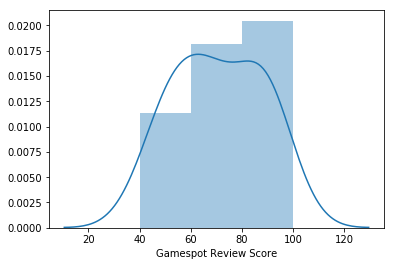

In [83]:
sns.distplot(clean_data['Gamespot Review Score'])

In [84]:
clean_data['Metacritic Review Score'].describe()

count    22.000000
mean     75.090909
std      13.215824
min      51.000000
25%      65.500000
50%      78.500000
75%      83.750000
max      96.000000
Name: Metacritic Review Score, dtype: float64

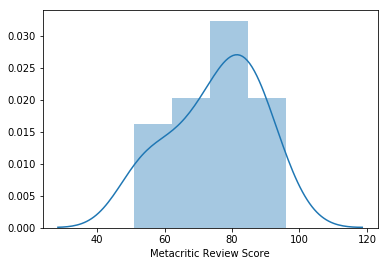

In [85]:
sns.distplot(clean_data['Metacritic Review Score'])

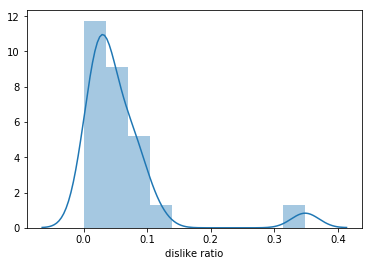

In [86]:
sns.distplot(clean_data['dislike ratio'])

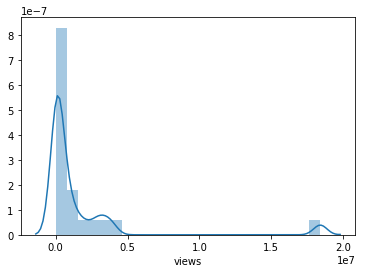

In [87]:
sns.distplot(clean_data['views'])

**What was the game with the best score according to Gamespot? And Metacritic?**

In [88]:
clean_data.loc[clean_data['Gamespot Review Score'].idxmax()]

game_name                  The Legend of Zelda: Breath of the Wild
views                                                     18414127
Metacritic Review Score                                         96
Gamespot Review Score                                          100
dislike ratio                                             0.017575
Release Date                                   2017-03-03 00:00:00
date_published_yt                              2017-01-12 00:00:00
Name: 18, dtype: object

In [89]:
clean_data.loc[clean_data['Metacritic Review Score'].idxmax()]

game_name                  The Legend of Zelda: Breath of the Wild
views                                                     18414127
Metacritic Review Score                                         96
Gamespot Review Score                                          100
dislike ratio                                             0.017575
Release Date                                   2017-03-03 00:00:00
date_published_yt                              2017-01-12 00:00:00
Name: 18, dtype: object

**What was the game with the worst score according to Gamespot? And Metacritic?**

In [90]:
clean_data.loc[clean_data['Gamespot Review Score'].idxmin()]

game_name                            Syberia 3
views                                   125831
Metacritic Review Score                     51
Gamespot Review Score                       40
dislike ratio                         0.348361
Release Date               2012-09-05 00:00:00
date_published_yt          2017-04-19 00:00:00
Name: 7, dtype: object

In [91]:
clean_data.loc[clean_data['Metacritic Review Score'].idxmin()]

game_name                            Syberia 3
views                                   125831
Metacritic Review Score                     51
Gamespot Review Score                       40
dislike ratio                         0.348361
Release Date               2012-09-05 00:00:00
date_published_yt          2017-04-19 00:00:00
Name: 7, dtype: object

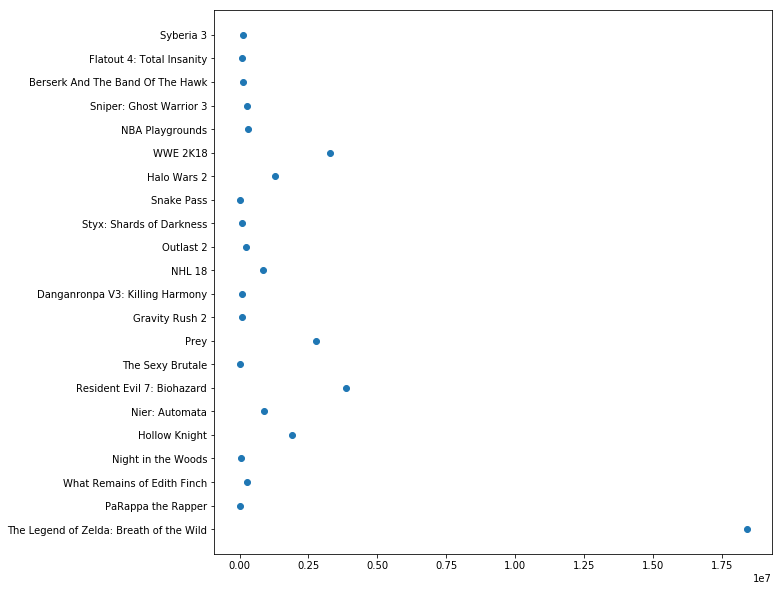

In [92]:
plt.figure(figsize=(10,10))
plt.scatter(x=clean_data['views'], y=clean_data['game_name'])

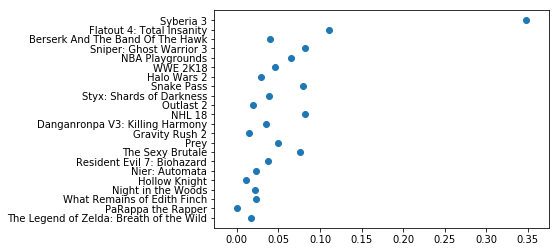

In [93]:
plt.scatter(x=clean_data['dislike ratio'], y= clean_data['game_name'])

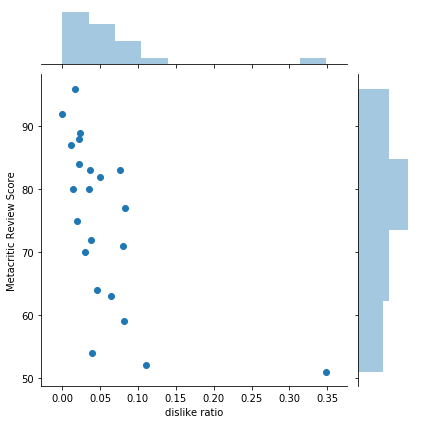

In [94]:
sns.jointplot(clean_data['dislike ratio'], clean_data['Metacritic Review Score'])

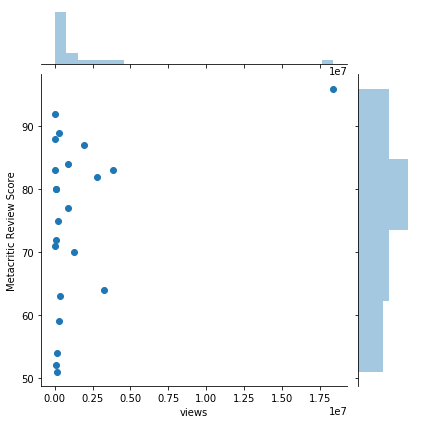

In [95]:
sns.jointplot(clean_data['views'], clean_data['Metacritic Review Score'])

Sample without videos with more than 1 million views

In [98]:
sample_2 = clean_data[clean_data['views'] < 250000]

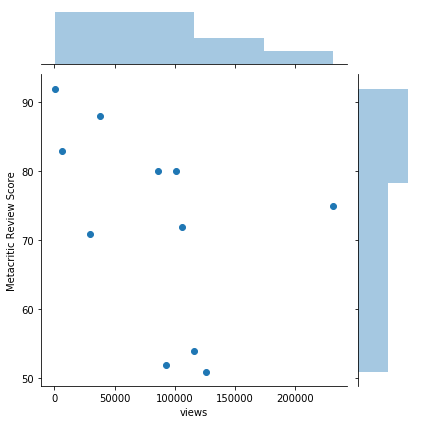

In [99]:
sns.jointplot(sample_2['views'], sample_2['Metacritic Review Score'])